<a href="https://colab.research.google.com/github/kmayutrisna/IMDB/blob/main/Amazon_Bert%2BCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential

In [3]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Display top of data
train_data =pd.read_csv("drive/My Drive/data/train_amazon.csv")
test_data = pd.read_csv("drive/My Drive/data/test_amazon.csv")

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Text preprocessing
from nltk.corpus import stopwords
def preprocess_text(text):

    # Text cleaning
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercasing
    text = text.lower()

    # Lowercasing
    text = text.split()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]

    # Join the tokens back to a single string
    text = ' '.join(text)
    return text

In [7]:
# Preprocess the text column
train_data['text'] = train_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)

In [8]:
# Preprocess the text data
X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

In [9]:
# Define the tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [10]:
# Tokenize the texts and pad the sequences
train_encodings = tokenizer.batch_encode_plus(
    X_train.tolist(),
    truncation=True,
    padding=True,
    return_token_type_ids=False,
    max_length=512
)


test_encodings = tokenizer.batch_encode_plus(
    X_test.tolist(),
    truncation=True,
    padding=True,
    return_token_type_ids=False,
    max_length=512
)

In [11]:
# Convert the tokenized inputs to numpy arrays
train_inputs = np.array(train_encodings['input_ids'])
train_labels = np.array(y_train)
test_inputs = np.array(test_encodings['input_ids'])
test_labels = np.array(y_test)

In [12]:
# Pad the sequences
train_pad = pad_sequences(train_inputs, maxlen=512)
test_pad = pad_sequences(test_inputs, maxlen=512)

In [13]:
# Build CNN Model
model = Sequential()
model.add(Embedding(30522, 100, input_length=512))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 100)          3052200   
                                                                 
 conv1d (Conv1D)             (None, 508, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 101, 128)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12928)             0         
                                                                 
 dense (Dense)               (None, 1)                 12929     
                                                                 
Total params: 3129257 (11.94 MB)
Trainable params: 3129257 (11.94 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [15]:
# Train the Model
epochs = 5
batch_size = 128

history = model.fit(train_pad, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
225/225 [==============================] - 177s 779ms/step - loss: 0.4101 - accuracy: 0.7958 - val_loss: 0.2927 - val_accuracy: 0.8746
Epoch 2/5
225/225 [==============================] - 171s 759ms/step - loss: 0.1882 - accuracy: 0.9293 - val_loss: 0.3139 - val_accuracy: 0.8726
Epoch 3/5
225/225 [==============================] - 170s 755ms/step - loss: 0.1010 - accuracy: 0.9665 - val_loss: 0.4020 - val_accuracy: 0.8629
Epoch 4/5
225/225 [==============================] - 157s 698ms/step - loss: 0.0394 - accuracy: 0.9898 - val_loss: 0.5300 - val_accuracy: 0.8586
Epoch 5/5
225/225 [==============================] - 159s 709ms/step - loss: 0.0128 - accuracy: 0.9976 - val_loss: 0.6433 - val_accuracy: 0.8549


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Assuming you already have predictions and test_labels
predictions = model.predict(test_pad)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, predictions)
print(f"MCC Score: {mcc * 100:.2f}%")


125/125 [==============================] - 16s 122ms/step
Accuracy: 85.65%
Precision: 85.85%
Recall: 86.19%
F1 Score: 86.02%
MCC Score: 71.28%


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate and print classification report
report = classification_report(test_labels, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:\n", report)

# Calculate and print confusion matrix
confusion = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n", confusion)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.85      0.85      1951
    Positive       0.86      0.86      0.86      2049

    accuracy                           0.86      4000
   macro avg       0.86      0.86      0.86      4000
weighted avg       0.86      0.86      0.86      4000

Confusion Matrix:
 [[1660  291]
 [ 283 1766]]


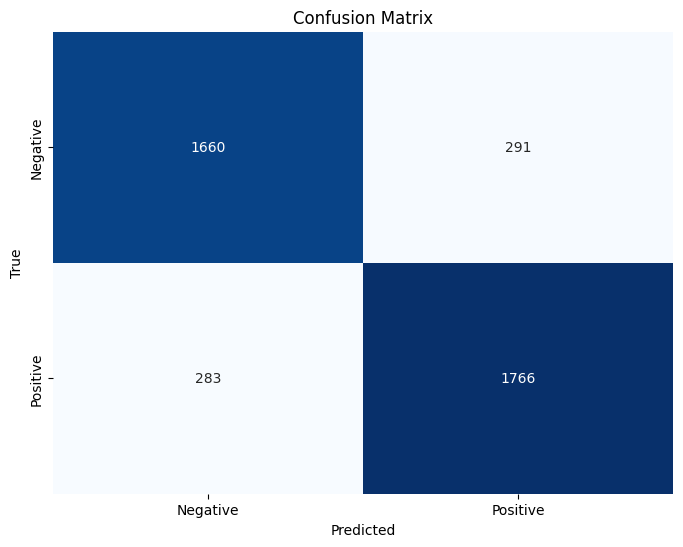

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion = confusion_matrix(test_labels, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

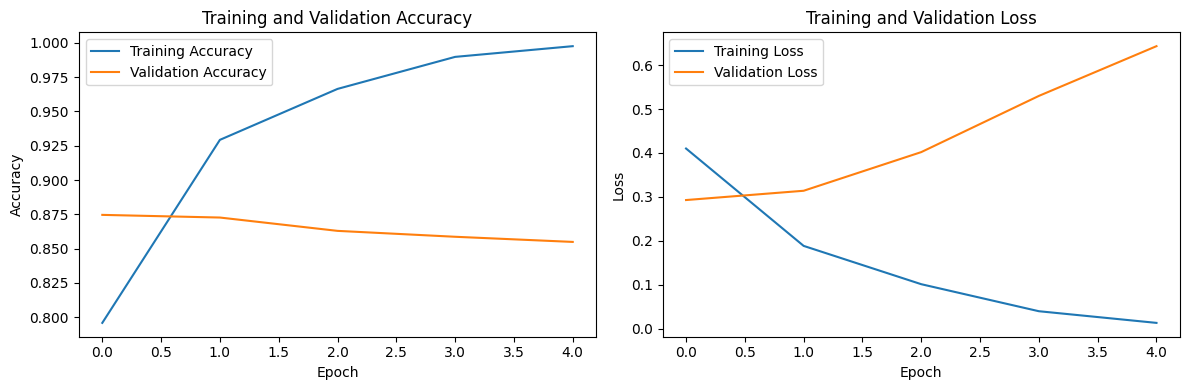

In [19]:
# Plot Training History (Accuracy and Loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
